# Apply CCR framework

This is an example for applying the [Cognition, Contagion and behavioral Response (CCR Framework)](../../docs/background.md#human-behaviour-framework) with `ABSESpy`. This framework consisted by three parts:

- **Cognition** represents the human processing of information around the ecological system.
- **Contagion** represents spreading information, beliefs and behaviour through social networks.
- **Response** is the resultant behaviour or action.


To apply this cognition-contagion-response (CCR) human behaviour modelling framework, `ABSESpy`'s users can:

1. define cognition functions for actors (agents); 
2. generate a network in human modules;
3. in a human model, define [action arena](#TODO) functions of actors' interactions or responses. 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import sys
import os

os.chdir("../../..")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.facecolor'] = 'white'


## Example model

As an example, we demonstrate an adapted simple but classic Agent-based model of `Wealth Transferring`. Other popular Agent-based modelling software (e.g., `NetLogo`) or packages (`AgentPy` and `MESA`) both include this model in their model libraries. 

The model explores the distribution of wealth under a trading population of agents. Each agent starts with one unit of wealth. During each time-step, each agents with positive wealth randomly selects a trading partner and gives them one unit of their wealth. We will see that this random interaction will create an inequality of wealth that follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf). 

Here we will rewrite the model in the framework of CCR and add geographical distance as a parameter to the classical model. It is shown how actors perceive other actors, how behaviors "spreads" between actors and how "transaction scenarios" are automatically formed between actors.

### Original Model Framework

Referring codes from the [`AgentPy` package](https://agentpy.readthedocs.io/en/latest/agentpy_wealth_transfer.htmlhttps://agentpy.readthedocs.io/en/latest/agentpy_wealth_transfer.html)

Frist of all, define the actors' behaviour. 

In [2]:
from abses import Actor
from typing import Optional, Self


class WealthyActor(Actor):

    """ Demo model of wealth transferring. """

    def setup(self):
        self.wealth = 1

    def wealth_transfer(self, partner: Optional[Self] = None):
        if partner is None:
            partner = self.model.all_agents.random_choose()
        if self.wealth > 0:
            partner.wealth += 1
            self.wealth -= 1


Then, define the metrics (Gini coefficient) and model workflow.

In [3]:
from abses import MainModel


def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799

    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad


class WealthModel(MainModel):

    """ A simple model of random wealth transfers """

    def setup(self):
        actors = self.agents.create(WealthyActor, 100)

    def step(self):
        self.all_agents.wealth_transfer()

    def update(self):
        self.record('Gini Coefficient', gini(self.all_agents.wealth))

    def end(self):
        self.all_agents.record('wealth')

Input parameters to the model, and show Gini coefficient results.

In [4]:
parameters = {
    'wealth demo': {
        'agents': 100,
        'steps': 100,
        'seed': 42,
    }
}

model = WealthModel(name='wealth demo', base='tests', parameters=parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:04.368514
Simulation finished


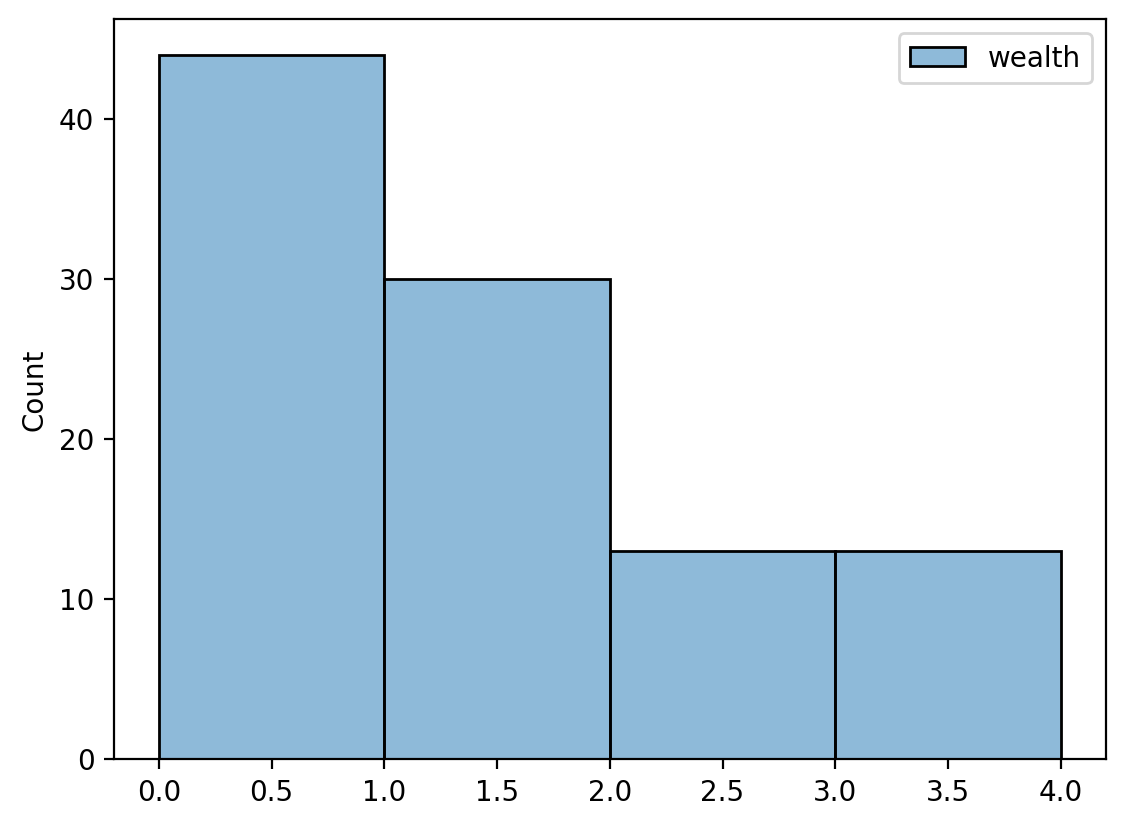

In [5]:
sns.histplot(data=results.variables.WealthyActor, binwidth=1);

### Adapted wealth transferring problem

1. An actor can only trade with nearby actors (with a parameter of distance 'd').
2. If actor feel his community is not aproprate for his economic class, he will move randomly.
3. If actors have the similar properties within the community, he likes to trade with neighbors.

<img src="https://songshgeo-picgo-1302043007.cos.ap-beijing.myqcloud.com/uPic/2jFmIS.jpg" alt="Drawing" style="width: 400px;"/>

In [6]:
from abses.actor import perception, link_to, check_rule


class WealthyActor(Actor):

    """Demo model of wealth transferring."""

    def setup(self):
        self.wealth: int = 1
        self.rule(when="fit_in == False", then="move", check_now=False, frequency='now')

    # setup property 'potential partner',
    # which auto links to these potential partners.
    @link_to
    def potential_partners(self):
        return self.neighbors(distance=5)

    @perception
    def fit_in(self) -> bool:
        if len(self.potential_partners) == 0:
            return False
        # others_wealth = self.potential_partners.wealth
        # lower = self.wealth < others_wealth.mean() - others_wealth.std()
        # higher = self.wealth > others_wealth.mean() + others_wealth.std()
        # if lower or higher:
        #     return False
        else:
            return True

    @check_rule(loop=True)
    def wealth_transfer(self):
        partner = self.potential_partners.random_choose()
        if self.wealth > 0:
            partner.wealth += 1
            self.wealth -= 1


class WealthModel(MainModel):

    """A simple model of random wealth transfers"""

    def setup(self):
        actors = self.agents.create(WealthyActor, 100)
        self.nature.add_agents(actors, replace=True)

    def step(self):
        self.all_agents.wealth_transfer()

    def update(self):
        self.record("Gini Coefficient", gini(self.all_agents.wealth))

    def end(self):
        self.all_agents.record("wealth")

In [7]:
parameters = {
    'wealth demo': {
        'agents': 100,
        'steps': 100,
        'seed': 42,
    }
}

model = WealthModel(name='wealth demo', base='tests', parameters=parameters)
results = model.run()

Completed: 100 steps
Run time: 0:01:06.022963
Simulation finished


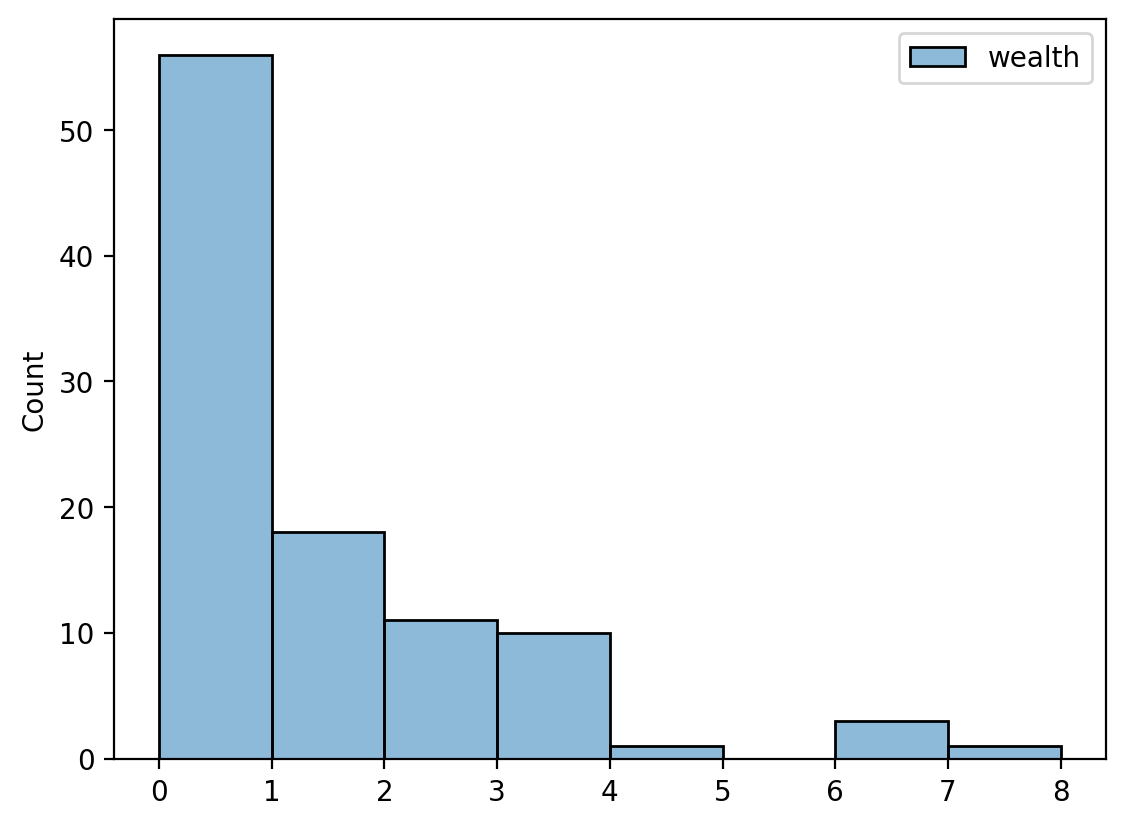

In [8]:
sns.histplot(data=results.variables.WealthyActor, binwidth=1);

In [9]:
results.variables.WealthyActor

,,wealth
obj_id,t,
43,100,2
59,100,0
75,100,1
8,100,3
91,100,1
...,...,...
42,100,0
58,100,0
74,100,0
